## Rover Project Test Notebook

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio



### Quick Look at the Recorded Data and testing it

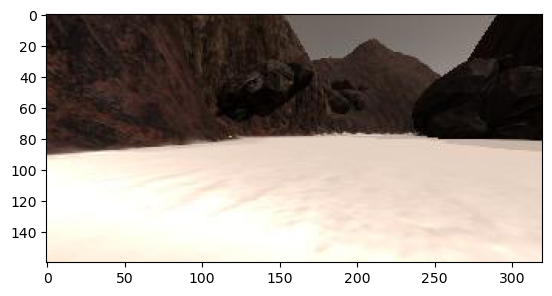

In [2]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

### Calibration of Our Recorded Data

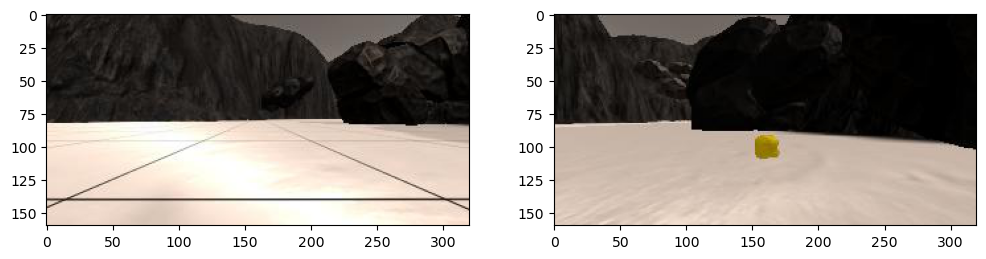

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

### Perspective Transform 

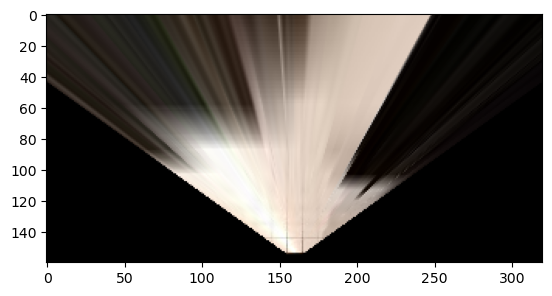

In [4]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
#is not the position of the rover but a bit in front of it
bottom_offset = 6
src = np.float32([[13, 140], [302 ,140],[200, 96], [118, 96]])
dst = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, src, dst)
plt.imshow(warped)


### Perform Color Thresholding of Navigable terrain, Obstacles and Sample Rocks
Define the color thresholding function from the lesson and apply it to the warped image

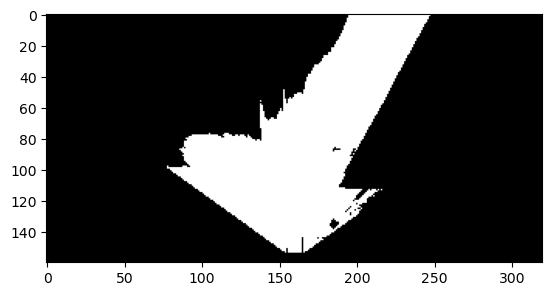

In [5]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def navigable_thresh(img, rgb_thresh=(160, 160, 160)):
    
    # Create an array of zeros with the same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    above_thresh = ((img[:,:,0] > rgb_thresh[0]) &
                    (img[:,:,1] > rgb_thresh[1]) &
                    (img[:,:,2] > rgb_thresh[2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    return color_select

threshed = navigable_thresh(warped)
plt.imshow(threshed, cmap='gray')

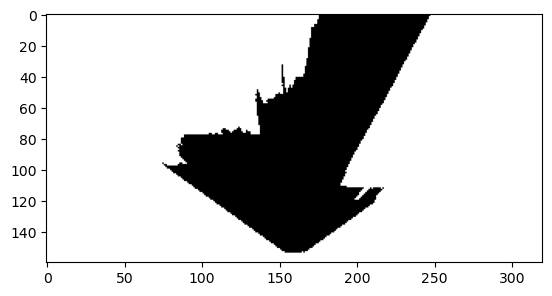

In [6]:
def obstacle_thresh(img, rgb_thresh=(160, 160, 160)):
   
    # Create an array of zeros with the same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be below all three threshold values in rbg_thresh.
    #   Values below the threshold will now contain a boolean array with TRUE.
    below_thresh = ((img[:,:,0] < rgb_thresh[0]) &
                    (img[:,:,1] < rgb_thresh[1]) &
                    (img[:,:,2] < rgb_thresh[2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 1
    return color_select

obstacles = obstacle_thresh(warped)
plt.imshow(obstacles, cmap='gray')

### Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

/tmp/ipykernel_23267/1381750509.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_23267/1381750509.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)


0.5000456600917869


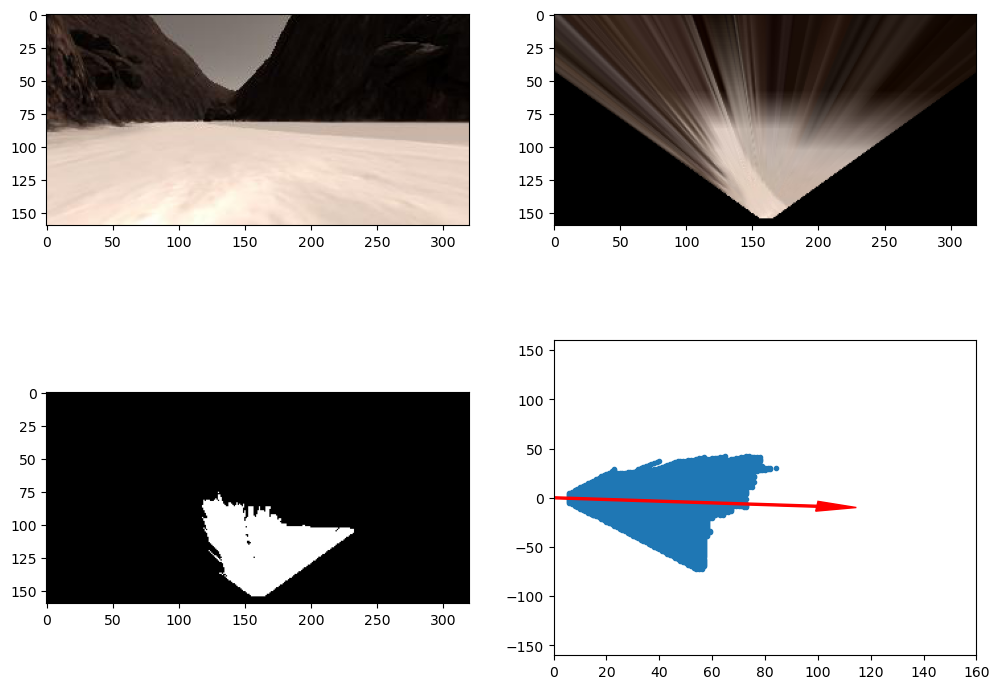

In [13]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Translate the pixel positions with reference to the rover position being
    #   at the center bottom of the image. Must flip the xpos and ypos.
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Calculate distance to each pixel using pythagoream theorem
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel using arc tangent
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw degrees to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a matrix rotation counter-clockwise by the yaw radians
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Scale and translate the rotated pixel arrays
    xpix_translated = (xpos + (xpix_rot / scale))
    ypix_translated = (ypos + (ypix_rot / scale))
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale=10):
    # Rotate the coordinates so x and y axes are parallel to the world axes
    xpix_rot, ypix_rot = rotate_pix(xpix=xpix, ypix=ypix, yaw=yaw)
    # Translate the rotated arrays by the rover's location in the world
    xpix_tran, ypix_tran = translate_pix(xpix_rot=xpix_rot, ypix_rot=ypix_rot,
                                         xpos=xpos, ypos=ypos, scale=scale)
    # Clip the array ranges to fit within the world map
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, src, dst)
threshed = navigable_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles) 
print(np.std(angles))
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

fig.savefig('../misc/analys.jpg')

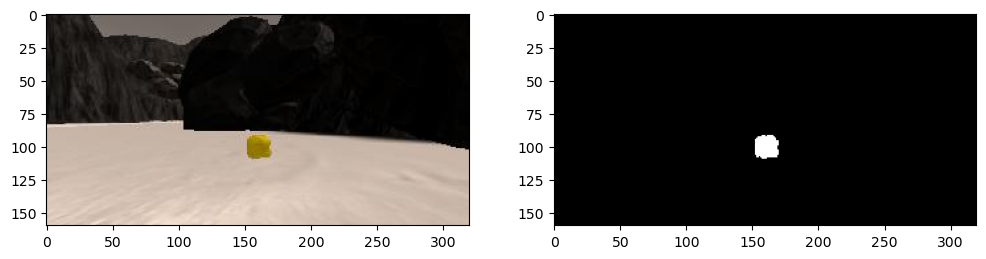

In [14]:
def rock_thresh(img):
   
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV, 3)
    
    # Define range of yellow colors in HSV
    lower_yellow = np.array([20, 150, 100], dtype='uint8')
    upper_yellow = np.array([50, 255, 255], dtype='uint8')
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask 


rock_map = rock_thresh(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

fig.savefig('../misc/rok_threshed.jpg')

### Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

In [15]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


/tmp/ipykernel_23267/550296272.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
/tmp/ipykernel_23267/550296272.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3)).astype(np.float)


### Write a function to process stored images

In [27]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
def perception_step(img):
    
    # 1) Define source and destination points for perspective transform
    dst_size = 5
    bottom_offset = 6
    src = np.float32([[13, 140], [302 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                      [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                      ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(img, src, dst)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = navigable_thresh(warped, (160, 160, 160))    # (220, 220, 200)
    obstacles = obstacle_thresh(warped, (160, 160, 160))     # (90, 90, 90)
    rock_samples = rock_thresh(warped)
    
    navigable[0:int(navigable.shape[0]/2),:] = 0
    obstacles[0:int(obstacles.shape[0]/2),:] = 0
    
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_xpix, navigable_ypix = rover_coords(navigable)
    obstacles_xpix, obstacles_ypix = rover_coords(obstacles)
    rocks_xpix, rocks_ypix = rover_coords(rock_samples)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 20
    
        # This will fail for the last frame. idk.
    xpos, ypos = data.xpos[data.count], data.ypos[data.count]
    yaw = data.yaw[data.count]

    worldmap_size = data.worldmap.shape[0]
    navigable_x_world, navigable_y_world = pix_to_world(
    navigable_xpix, navigable_ypix,
    xpos, ypos, yaw, worldmap_size, scale)
    obstacles_x_world, obstacles_y_world = pix_to_world(
    obstacles_xpix, obstacles_ypix,
    xpos, ypos, yaw, worldmap_size, scale)
    rocks_x_world, rocks_y_world = pix_to_world(
    rocks_xpix, rocks_ypix,
    xpos, ypos, yaw, worldmap_size, scale)

    # 6) Update worldmap (to be displayed on right side of screen)
    # world map is updated according to the pitch and roll angles
    # of the rover if (Rover.pitch < 2 or Rover.pitch > 358) 
    # and (Rover.roll < 1 or Rover.roll > 359):
    data.worldmap[obstacles_y_world, obstacles_x_world, 0] += 1
    data.worldmap[rocks_y_world, rocks_x_world, 1] = 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
    # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, src, dst)
    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    # Then putting some text over the image
    cv2.putText(output_image,"Navigable: Blue/Pink; Obstacle: Red; Sample Rock: Yellow", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)

    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [28]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(perception_step) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
CPU times: user 4.16 s, sys: 129 ms, total: 4.29 s
Wall time: 6.09 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

### Playing the processed video

In [29]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

In [ ]:
# save automated rover run clip
#output = '../output/rover_mapping.mp4'
#data = Databucket() 
#clip = ImageSequenceClip('../test_dataset1', fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25   
#new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time new_clip.write_videofile(output, audio=False)